In [125]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

In [6]:
image_size = (28, 28)

def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

labels = ["eye", "square", "circle", "star"]

for label in labels:
    generate_class_images(label, max_drawings=2000, recognized=True)

downloading eye from https://storage.googleapis.com/quickdraw_dataset/full/binary/eye.bin
download complete
loading eye drawings
load complete
downloading square from https://storage.googleapis.com/quickdraw_dataset/full/binary/square.bin
download complete
loading square drawings
load complete
downloading circle from https://storage.googleapis.com/quickdraw_dataset/full/binary/circle.bin
download complete
loading circle drawings
load complete
downloading star from https://storage.googleapis.com/quickdraw_dataset/full/binary/star.bin
download complete
loading star drawings
load complete


In [124]:
batch_size = 32
image_size = (28, 28)

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 7678 files belonging to 4 classes.
Using 6143 files for training.
Found 7678 files belonging to 4 classes.
Using 1535 files for validation.


2025-07-16 19:22:51.718582: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


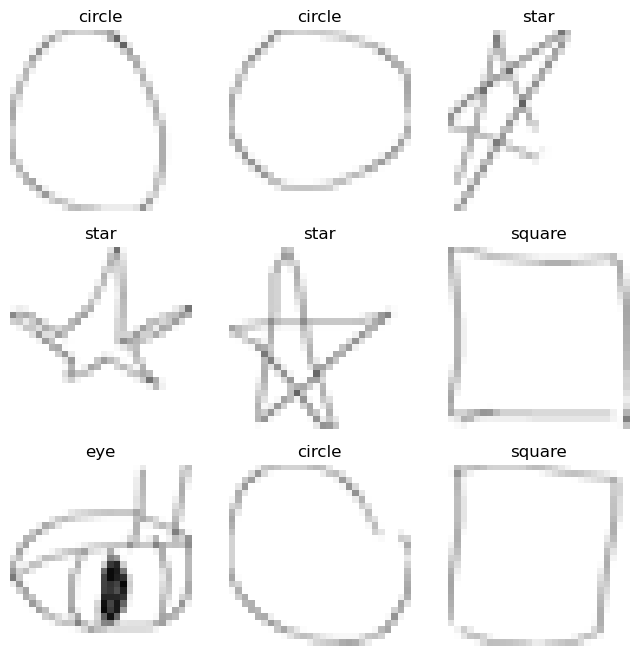

In [120]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [126]:
import numpy as np
import os
import cv2

def load_dataset(dataset_path):
    X, y = [], []
    class_names = sorted([
        name for name in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, name))
    ])
    class_map = {name: idx for idx, name in enumerate(class_names)}
    
    for label in class_names:
        folder_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (28, 28))
            edges = cv2.Canny(img, 100, 200)
            X.append(edges)
            y.append(class_map[label])
    
    X = np.array(X).reshape(-1, 28, 28, 1) / 255.0
    y = to_categorical(y, num_classes=len(class_names))
    return X, y, class_names


In [127]:
X, y, class_names = load_dataset('dataset')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,260 (876.02 KB)

 Trainable params: 224,260 (876.02 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8212 - loss: 0.5076 - val_accuracy: 0.9674 - val_loss: 0.0969
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9661 - loss: 0.1097 - val_accuracy: 0.9772 - val_loss: 0.0684
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9789 - loss: 0.0655 - val_accuracy: 0.9785 - val_loss: 0.0700
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9818 - loss: 0.0483 - val_accuracy: 0.9785 - val_loss: 0.0614
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9868 - loss: 0.0381 - val_accuracy: 0.9824 - val_loss: 0.0577
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9900 - loss: 0.0385 - val_accuracy: 0.9844 - val_loss: 0.0603
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0261 - val_accuracy: 0.9811 - val_loss: 0.0653
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9954 - loss: 0.0157 - val_accuracy: 0.

In [106]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_acc:.2f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0953
Validation accuracy: 0.98


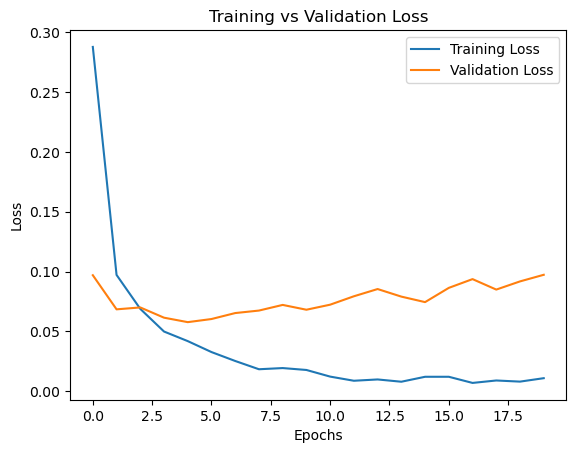

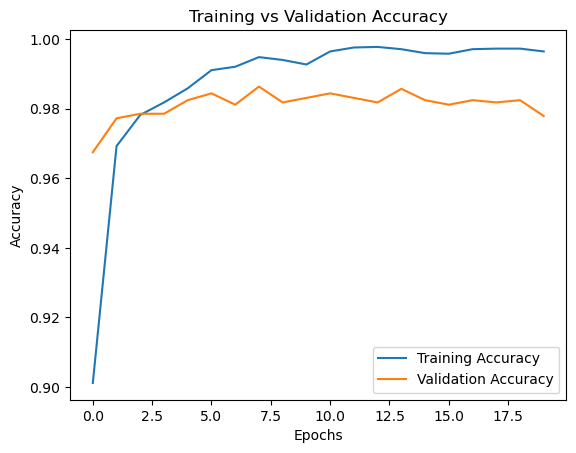

In [128]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      circle       0.98      1.00      0.99       412
         eye       0.96      0.97      0.96       377
      square       1.00      0.99      1.00       380
        star       0.98      0.95      0.96       367

    accuracy                           0.98      1536
   macro avg       0.98      0.98      0.98      1536
weighted avg       0.98      0.98      0.98      1536

Akurasi: 0.9779


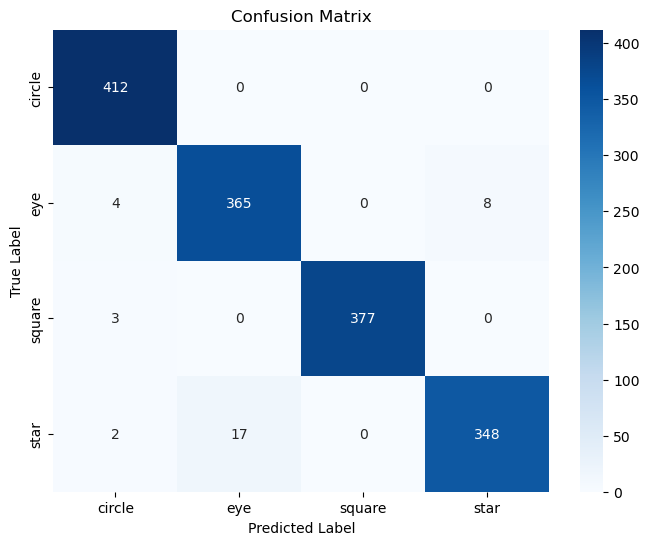

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Akurasi
acc = accuracy_score(y_true, y_pred)
print(f"Akurasi: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [116]:
model.save("model_canny_cnn.h5")


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("model_canny_cnn.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Konversi ke .tflite berhasil.")

INFO:tensorflow:Assets written to: /var/folders/21/cwhj0nm1103ds_nxryvp_jsh0000gq/T/tmpejy4s_g_/assets


INFO:tensorflow:Assets written to: /var/folders/21/cwhj0nm1103ds_nxryvp_jsh0000gq/T/tmpejy4s_g_/assets


Saved artifact at '/var/folders/21/cwhj0nm1103ds_nxryvp_jsh0000gq/T/tmpejy4s_g_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_123')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  15159170976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159173968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159170800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159171504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159164992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159168512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159168336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15159166048: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Konversi ke .tflite berhasil.


W0000 00:00:1752668541.667242  196515 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752668541.667275  196515 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-16 19:22:21.667465: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/21/cwhj0nm1103ds_nxryvp_jsh0000gq/T/tmpejy4s_g_
2025-07-16 19:22:21.667764: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-16 19:22:21.667768: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/21/cwhj0nm1103ds_nxryvp_jsh0000gq/T/tmpejy4s_g_
I0000 00:00:1752668541.670269  196515 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-07-16 19:22:21.670685: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-16 19:22:21.687103: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder